# Naive approach random_forest + optuna

In [61]:
model_name = 'random_forest'

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "./data/"
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

# drop id
df_train.drop('id', axis=1, inplace=True)

df_train['date'] = pd.to_datetime(df_train['date'])

df_train.head(10)

,date,country,store,product,num_sold
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


In [63]:
def create_features(df):
    # split date into year, month, day
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    # week number
    df['week_number'] = df['date'].dt.isocalendar().week.astype(int)
    
    # day of week
    df['dayofweek'] = df['date'].dt.dayofweek

    # weekend
    df['weekend'] = (df['date'].dt.weekday >=4).astype(int)

    # drop date
    df = df.drop('date', axis=1)

    # one-hot encoding of 'country', 'store', 'product' columns
    #df_train = pd.get_dummies(df_train, columns=['country', 'store', 'product'])


    df['country'] = df['country'].astype('category')
    df['store'] = df['store'].astype('category')
    df['product'] = df['product'].astype('category')

    return df

df_train_0 = create_features(df_train)

model_features = ['country', 'store', 'product', 'year', 'month', 'day', 'week_number', 'dayofweek', 'weekend']

df_train_0.head(10)

,country,store,product,num_sold,year,month,day,week_number,dayofweek,weekend
0,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,2017,1,1,52,6,1
1,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,2017,1,1,52,6,1
2,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,2017,1,1,52,6,1
3,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,2017,1,1,52,6,1
4,Argentina,Kaggle Learn,Using LLMs to Write Better,49,2017,1,1,52,6,1
5,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88,2017,1,1,52,6,1
6,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98,2017,1,1,52,6,1
7,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14,2017,1,1,52,6,1
8,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83,2017,1,1,52,6,1
9,Argentina,Kaggle Store,Using LLMs to Write Better,69,2017,1,1,52,6,1


In [64]:
def encode_cat_variables(df):
    categorical_features = ["country", "store", "product"]
    df = pd.get_dummies(df, columns=categorical_features)
    return df


df_train_0 = encode_cat_variables(df_train_0)
df_train_0.head()

,num_sold,year,month,day,week_number,dayofweek,weekend,country_Argentina,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
0,63,2017,1,1,52,6,1,True,False,False,False,False,False,True,False,True,False,False,False,False
1,66,2017,1,1,52,6,1,True,False,False,False,False,False,True,False,False,True,False,False,False
2,9,2017,1,1,52,6,1,True,False,False,False,False,False,True,False,False,False,True,False,False
3,59,2017,1,1,52,6,1,True,False,False,False,False,False,True,False,False,False,False,True,False
4,49,2017,1,1,52,6,1,True,False,False,False,False,False,True,False,False,False,False,False,True


In [65]:
model_features = df_train_0.columns.tolist()
model_features.remove("num_sold")
model_features

['year',
 'month',
 'day',
 'week_number',
 'dayofweek',
 'weekend',
 'country_Argentina',
 'country_Canada',
 'country_Estonia',
 'country_Japan',
 'country_Spain',
 'store_Kagglazon',
 'store_Kaggle Learn',
 'store_Kaggle Store',
 'product_Using LLMs to Improve Your Coding',
 'product_Using LLMs to Train More LLMs',
 'product_Using LLMs to Win Friends and Influence People',
 'product_Using LLMs to Win More Kaggle Competitions',
 'product_Using LLMs to Write Better']

In [66]:
df_train_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 20 columns):
 #   Column                                                  Non-Null Count   Dtype
---  ------                                                  --------------   -----
 0   num_sold                                                136950 non-null  int64
 1   year                                                    136950 non-null  int32
 2   month                                                   136950 non-null  int32
 3   day                                                     136950 non-null  int32
 4   week_number                                             136950 non-null  int32
 5   dayofweek                                               136950 non-null  int32
 6   weekend                                                 136950 non-null  int32
 7   country_Argentina                                       136950 non-null  bool 
 8   country_Canada                              

Function by which submissions are scored is SMAPE:

In [67]:
def SMAPE(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [68]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
import optuna

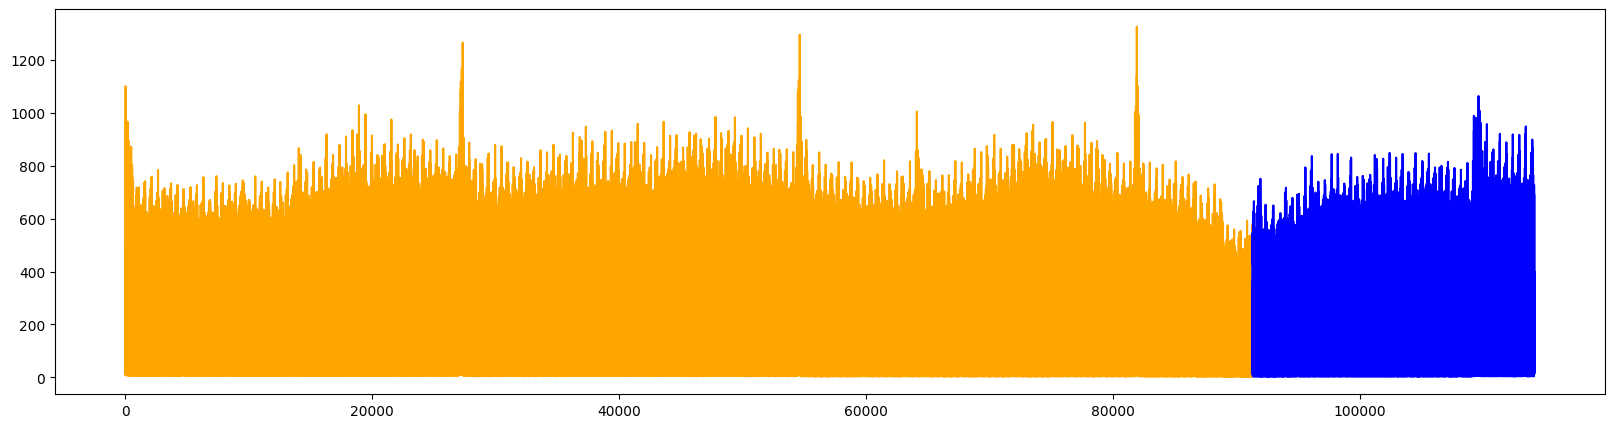

In [69]:
# get small split of data for hyperparameter tuning

train_index, val_index = [ x for x in TimeSeriesSplit(n_splits=5).split(df_train_0) ][-2]

X_train = df_train_0.iloc[train_index][model_features]
y_train = df_train_0.iloc[train_index]['num_sold']

X_val = df_train_0.iloc[val_index][model_features]
y_val = df_train_0.iloc[val_index]['num_sold']

# plot X_train and X_val
plt.figure(figsize=(20, 5))
plt.plot(X_train.index, y_train, color="orange", label='train')
plt.plot(X_val.index, y_val, color="blue", label='val')
plt.show()

In [70]:
X_train.info()

cat_features_indices = np.where((X_train.dtypes == "category") | (X_train.dtypes == "object"))[0]
cat_features_indices

<class 'pandas.core.frame.DataFrame'>
Index: 91300 entries, 0 to 91299
Data columns (total 19 columns):
 #   Column                                                  Non-Null Count  Dtype
---  ------                                                  --------------  -----
 0   year                                                    91300 non-null  int32
 1   month                                                   91300 non-null  int32
 2   day                                                     91300 non-null  int32
 3   week_number                                             91300 non-null  int32
 4   dayofweek                                               91300 non-null  int32
 5   weekend                                                 91300 non-null  int32
 6   country_Argentina                                       91300 non-null  bool 
 7   country_Canada                                          91300 non-null  bool 
 8   country_Estonia                                         91300

array([], dtype=int64)

In [71]:
def objective(trial):
    model = RandomForestRegressor(
        n_estimators=trial.suggest_int('n_estimators', 100, 1000),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(
        X_train, y_train,
    )

    return SMAPE(y_val, np.round(model.predict(X_val)))


#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=50)

best_hyperparams = {'n_estimators': 201, 'max_depth': 10} # study.best_params

In [72]:
best_hyperparams

{'n_estimators': 201, 'max_depth': 10}

In [73]:
# split into train and validation


results_smape = []
results_r2 = []
results_mse = []


N_SPLITS = 5

for train_index, val_index in TimeSeriesSplit(n_splits=N_SPLITS).split(df_train_0):
    X_train = df_train_0.iloc[train_index][model_features]
    y_train = df_train_0.iloc[train_index]['num_sold']

    X_val = df_train_0.iloc[val_index]
    y_val = df_train_0.iloc[val_index]['num_sold']

    model = RandomForestRegressor(**best_hyperparams)
    model.fit(X_train, y_train)

    # evaluate on validation set
    y_pred = np.round(model.predict(X_val[model_features]))

    smape = SMAPE(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)

    results_smape.append(smape)
    results_r2.append(r2)
    results_mse.append(mse)
    del model

print("Cross validated results:")

print("SMAPE: %s" % results_smape)
print("R2: %s" % results_r2)
print("MSE: %s" % results_mse)

print("Mean results:")
print("SMAPE: %.4f" % np.mean(results_smape))
print("R2: %.4f" % np.mean(results_r2))
print("MSE: %.4f" % np.mean(results_mse))


# add a row with results to csv file leaderboard.csv

row = [model_name, np.mean(results_smape), np.mean(results_r2), np.mean(results_mse)]
with open('leaderboard.csv', 'a') as fd:
    import csv
    fd.write('\n')
    writer = csv.writer(fd, delimiter=',', lineterminator=';\n')
    writer.writerow(row)

Cross validated results:
SMAPE: [12.888737148155688, 10.1365754072797, 12.7801164589928, 14.215134412726767, 11.962135512621556]
R2: [0.9668847986211403, 0.9792991436301102, 0.9595067730582927, 0.9625811026355966, 0.9522696256770409]
MSE: [1167.584578313253, 722.9695947426068, 1273.9441401971521, 1181.758335158817, 1870.472508214677]
Mean results:
SMAPE: 12.3965
R2: 0.9641
MSE: 1243.3458


In [74]:
df_train = pd.read_csv(data_path + "train.csv")
df_train['date'] = pd.to_datetime(df_train['date'])

df_train = create_features(df_train)

X_train = df_train_0.drop('num_sold', axis=1)
y_train = df_train_0['num_sold']


model = RandomForestRegressor(**best_hyperparams)
model.fit(X_train[model_features], y_train)

RandomForestRegressor(max_depth=10, n_estimators=201)

In [75]:
df_val = X_val.copy()
df_val['actual'] = y_val
df_val['prediction'] = model.predict(df_val[model_features])
df_val['prediction'] = df_val['prediction'].astype(int)
df_val

,num_sold,year,month,day,week_number,dayofweek,weekend,country_Argentina,country_Canada,country_Estonia,...,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,actual,prediction
114125,149,2021,3,2,9,1,0,False,False,False,...,False,False,True,True,False,False,False,False,149,148
114126,150,2021,3,2,9,1,0,False,False,False,...,False,False,True,False,True,False,False,False,150,148
114127,24,2021,3,2,9,1,0,False,False,False,...,False,False,True,False,False,True,False,False,24,23
114128,150,2021,3,2,9,1,0,False,False,False,...,False,False,True,False,False,False,True,False,150,136
114129,147,2021,3,2,9,1,0,False,False,False,...,False,False,True,False,False,False,False,True,147,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136945,700,2021,12,31,52,4,1,False,False,False,...,True,False,False,True,False,False,False,False,700,479
136946,752,2021,12,31,52,4,1,False,False,False,...,True,False,False,False,True,False,False,False,752,478
136947,111,2021,12,31,52,4,1,False,False,False,...,True,False,False,False,False,True,False,False,111,108
136948,641,2021,12,31,52,4,1,False,False,False,...,True,False,False,False,False,False,True,False,641,566


C:\Users\Wiktor\AppData\Local\Temp\ipykernel_24840\413032663.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['date'] = pd.to_datetime(X_val['year'].astype(str) + '-' + X_val['month'].astype(str) + '-' + X_val['day'].astype(str))
C:\Users\Wiktor\AppData\Local\Temp\ipykernel_24840\413032663.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.sort_values(by='date', inplace=True)


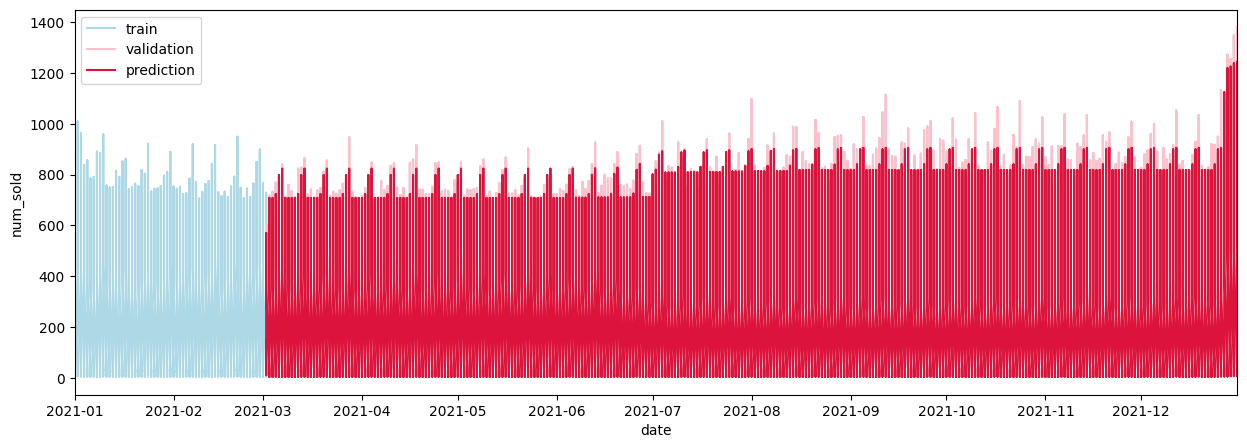

In [76]:
import datetime
X_train['date'] = pd.to_datetime(X_train['year'].astype(str) + '-' + X_train['month'].astype(str) + '-' + X_train['day'].astype(str))
X_val['date'] = pd.to_datetime(X_val['year'].astype(str) + '-' + X_val['month'].astype(str) + '-' + X_val['day'].astype(str))

df_val['date'] = pd.to_datetime(df_val['year'].astype(str) + '-' + df_val['month'].astype(str) + '-' + df_val['day'].astype(str))

# sort by date
X_train.sort_values(by='date', inplace=True)
X_val.sort_values(by='date', inplace=True)

# plot 'num_sold' vs 'date'
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(X_train['date'], y_train, label='train', color='lightblue')
ax.plot(X_val['date'], y_val, label='validation', color='pink')
ax.plot(df_val['date'], df_val['prediction'], label='prediction', color='crimson')

# x axis show only from 2021 onwards
ax.set_xlim([datetime.date(2021, 1, 1), df_val['date'].max()])
ax.set_xlabel('date')
ax.set_ylabel('num_sold')

ax.legend()
plt.show()

In [77]:
model_features

['year',
 'month',
 'day',
 'week_number',
 'dayofweek',
 'weekend',
 'country_Argentina',
 'country_Canada',
 'country_Estonia',
 'country_Japan',
 'country_Spain',
 'store_Kagglazon',
 'store_Kaggle Learn',
 'store_Kaggle Store',
 'product_Using LLMs to Improve Your Coding',
 'product_Using LLMs to Train More LLMs',
 'product_Using LLMs to Win Friends and Influence People',
 'product_Using LLMs to Win More Kaggle Competitions',
 'product_Using LLMs to Write Better']

In [78]:
df_test

,id,date,country,store,product
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better
...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions


In [79]:
# test 

df_test = pd.read_csv(data_path + "test.csv")

df_test['date'] = pd.to_datetime(df_test['date'])

df_test = create_features(df_test)
df_test = encode_cat_variables(df_test)

# predict for test set

df_test['prediction'] = model.predict(df_test[model_features])
df_test['prediction'] = df_test['prediction'].astype(int)
df_test

,id,year,month,day,week_number,dayofweek,weekend,country_Argentina,country_Canada,country_Estonia,...,country_Spain,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,prediction
0,136950,2022,1,1,52,5,1,True,False,False,...,False,False,True,False,True,False,False,False,False,36
1,136951,2022,1,1,52,5,1,True,False,False,...,False,False,True,False,False,True,False,False,False,35
2,136952,2022,1,1,52,5,1,True,False,False,...,False,False,True,False,False,False,True,False,False,4
3,136953,2022,1,1,52,5,1,True,False,False,...,False,False,True,False,False,False,False,True,False,34
4,136954,2022,1,1,52,5,1,True,False,False,...,False,False,True,False,False,False,False,False,True,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022,12,31,52,5,1,False,False,False,...,True,True,False,False,True,False,False,False,False,514
27371,164321,2022,12,31,52,5,1,False,False,False,...,True,True,False,False,False,True,False,False,False,513
27372,164322,2022,12,31,52,5,1,False,False,False,...,True,True,False,False,False,False,True,False,False,101
27373,164323,2022,12,31,52,5,1,False,False,False,...,True,True,False,False,False,False,False,True,False,566


In [80]:
df_test['num_sold'] = df_test['prediction']
df_test[['id', 'num_sold']].to_csv(f'{model_name}_submission.csv', index=False)